In [59]:
import timeit
import pandas as pd
import os
import numpy as np

In [60]:
movies_file = 'data/ml-10M100K/movies.dat'
ratings_file = 'data/ml-10M100K/ratings.dat'

# set static variables
_pickle_dir = os.path.join(os.path.dirname(
    os.path.abspath('eda2.ipynb')), 'data\pickled')

# set appropriate paths for pickle files
_ratings_pickle_filename = 'movie_ratings.pkl'
ratings_pickle_path = os.path.join(_pickle_dir, _ratings_pickle_filename)
_movies_pickle_filename = 'movies.pkl'
movies_pickle_path = os.path.join(_pickle_dir, _movies_pickle_filename)

# try to load from pickle if available
try:
    # load movies df from pickle if it exists
    if os.path.exists(movies_pickle_path+"2"):
        movies_df = pd.read_pickle(movies_pickle_path)
    else :
        movies_df = pd.read_csv(movies_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['movie_id', 'name', 'genres'],
                                        dtype={'movie_id': np.int32, 'name': np.chararray, 'genres': np.chararray})

    # load ratings df from pickle if it exists
    if os.path.exists(ratings_pickle_path+"2"):
        ratings_df = pd.read_pickle(ratings_pickle_path)
    else:
        ratings_df = pd.read_csv(ratings_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'],
                                        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.int32, 'timestamp': np.float64})
        ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s', utc=True)
# catch exceptions
except Exception as e:
    print(e)


In [61]:
# merge dataframes using inner join
merged_df = pd.merge(ratings_df, movies_df, how="inner", on="movie_id")

# make a set of movie_id where movie has Children genre
# children_movie_ids = set(merged_df.loc[merged_df['genres'].str.contains('Children', na=False), 'movie_id'])
# print(children_movie_ids)

# drop unnecessary columns for performance
# merged_df.drop(['timestamp', 'genres'], axis=1, inplace=True)

# take the average if user has multiple reviews for movie
merged_df = merged_df.groupby(
    by=['movie_id', 'user_id'], as_index=False).agg({"rating": "mean"})

# pivot to make movies as rows and users as columns
merged_df = merged_df.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)

# print(merged_df.shape)


In [65]:
existing_df = pd.read_json('recs-app/public/top_rated_similars_1000.json', orient="index")
print(merged_df.loc[296])
print(existing_df.columns)
existing_df['similar_movie_ids'] = [[]] * len(existing_df)


user_id
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
71563    0.0
71564    0.0
71565    0.0
71566    5.0
71567    0.0
Name: 296, Length: 69878, dtype: float64
Index(['substituted_name', 'description', 'avg_rating', 'num_ratings', 'name',
       'genres', 'movie_id', 'ranking', 'similar_movie_ids'],
      dtype='object')


In [66]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# use csr_matrix data type to represent pivot table of ratings as sparse matrix
sparse_item_df = csr_matrix(merged_df.values)
# create model from matrix
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_item_df)

for i in existing_df['movie_id'].values:
    weights, neighbors = model.kneighbors([merged_df.loc[i]], n_neighbors=50)
    neighbors = neighbors[0]  
    print(neighbors[:5])
    similar_movie_ids = list(merged_df.iloc[neighbors[1:4]].index)
    existing_df.at[existing_df[existing_df['movie_id'] == i].index[0], 'similar_movie_ids'] = similar_movie_ids

    for idx, n in enumerate(neighbors[1:4]):
        print(movies_df.loc[movies_df['movie_id'] == i]['name'].values[0],movies_df.loc[movies_df['movie_id'] == merged_df.index[n]]['name'].values[0])


[293 587 315  49  46]
Pulp Fiction (1994) Silence of the Lambs, The (1991)
Pulp Fiction (1994) Shawshank Redemption, The (1994)
Pulp Fiction (1994) Usual Suspects, The (1995)
[352 476 453 587 148]
Forrest Gump (1994) Jurassic Park (1993)
Forrest Gump (1994) Fugitive, The (1993)
Forrest Gump (1994) Silence of the Lambs, The (1991)
[587 293 315 453 352]
Silence of the Lambs, The (1991) Pulp Fiction (1994)
Silence of the Lambs, The (1991) Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991) Fugitive, The (1993)
[476 583 352 373 453]
Jurassic Park (1993) Terminator 2: Judgment Day (1991)
Jurassic Park (1993) Forrest Gump (1994)
Jurassic Park (1993) Speed (1994)
[315 293 587 352 148]
Shawshank Redemption, The (1994) Pulp Fiction (1994)
Shawshank Redemption, The (1994) Silence of the Lambs, The (1991)
Shawshank Redemption, The (1994) Forrest Gump (1994)
[108 352 453 476 583]
Braveheart (1995) Forrest Gump (1994)
Braveheart (1995) Fugitive, The (1993)
Braveheart (1995) Jurassic P

KeyboardInterrupt: 

In [ ]:
# save the updated dataframe
# existing_df.head()
# existing_df.to_json('data/top_rated_similars_1000.json', orient='index')


Text(0, 0.5, 'Frequency')

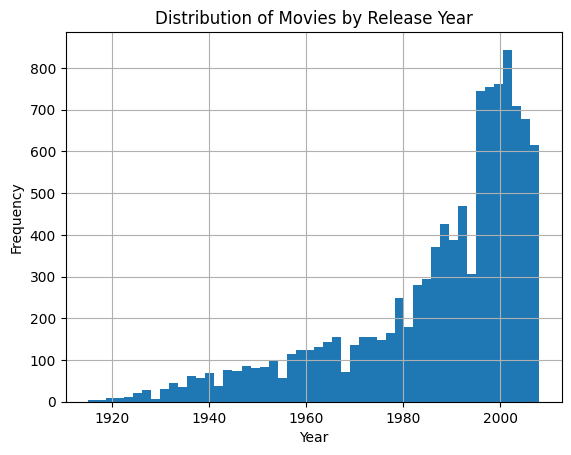

In [ ]:
import re
import matplotlib.pyplot as plt

# helper func to extract 4 digit year from movie title
def extract_year(name):
    pattern = r'\((\d{4})\)'
    match = re.search(pattern, name)
    if match:
        return int(match.group(1))
    else:
        return None

# create year column by applying extract_year
movies_df['year'] = movies_df['name'].apply(extract_year)
# merge movies and ratings
stats_df = pd.merge(movies_df, ratings_df, how='inner', on='movie_id')

# extract year values into list
years = movies_df['year'].values
# cast to pd Series and create histogram
pd.Series(years).hist(bins=50)

# set the plot title and axis labels
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Year')
plt.ylabel('Frequency')

# show the plot
# plt.show()


<AxesSubplot: >

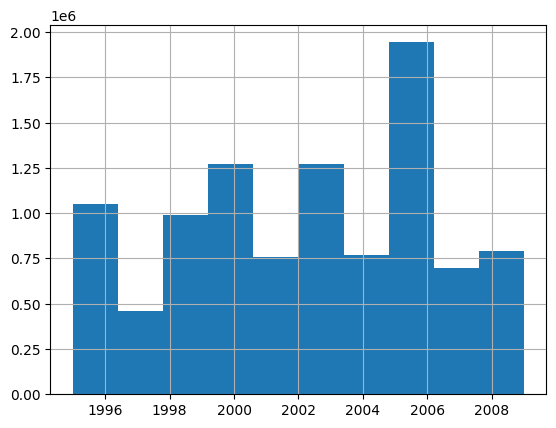

In [ ]:
import matplotlib.pyplot as plt

# print(ratings_df['timestamp'].head())
# pd.Series(ratings_df['timestamp']).hist(bins=50)

# Assume the timestamp column has already been converted to UTC datetime format
ratings_df['year'] = ratings_df['timestamp'].dt.year

# Plot a histogram of the year column
ratings_df['year'].hist()


In [95]:
# import tags by reading csv file
tags_df = pd.read_csv('data/ml-10M100K/tags.dat', sep='::', engine='python', encoding='utf-8', header=None, 
                      names=['user_id', 'movie_id', 'tag', 'timestamp'],
                      dtype={'user_id': np.int32, 'movie_id': np.int32, 'tag': np.chararray, 'timestamp': np.float64})
# drop columns that won't be used
tags_df.drop(['timestamp', 'user_id'], axis=1, inplace=True)

# group by movie_id and tag and count occurrences
grouped = tags_df.groupby(['movie_id', 'tag']).size().reset_index(name='count')

# rank tags within each movie_id group
ranked = grouped.groupby('movie_id')['count'].rank(ascending=False)
grouped['rank'] = ranked.astype(int)

# sort by movie_id and count in descending order
sorted_grouped_tags = grouped.sort_values(by=['movie_id', 'count'], ascending=[True, False])

# group by movie_id and select top 3 tags for each group
top_3_tags = sorted_grouped_tags.groupby('movie_id').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

# filter out tags with count less than or equal to 1
top_3_tags = top_3_tags[top_3_tags['count'] > 1]

# join with movie titles
top_3_tags = pd.merge(top_3_tags, movies_df, on='movie_id')

# display top 3 tags for each movie
for movie_id in existing_df['movie_id'][:10]:
    movie_title = movies_df[movies_df['movie_id'] == movie_id]['name']
    movie_tags = top_3_tags[top_3_tags['movie_id'] == movie_id]['tag']
    print(f"{movie_title}: {', '.join(movie_tags)}")


293    Pulp Fiction (1994)
Name: name, dtype: object: Quentin Tarantino, Tarantino, Samuel L. Jackson
352    Forrest Gump (1994)
Name: name, dtype: object: Tom Hanks, Oscar (Best Picture), Vietnam
587    Silence of the Lambs, The (1991)
Name: name, dtype: object: serial killer, cannibalism, Jodie Foster
476    Jurassic Park (1993)
Name: name, dtype: object: dinosaurs, Steven Spielberg, action
315    Shawshank Redemption, The (1994)
Name: name, dtype: object: prison, Stephen King, classic
108    Braveheart (1995)
Name: name, dtype: object: Mel Gibson, drama, overrated
453    Fugitive, The (1993)
Name: name, dtype: object: Harrison Ford, chase, crime
583    Terminator 2: Judgment Day (1991)
Name: name, dtype: object: time travel, robots, action
257    Star Wars: Episode IV - A New Hope (a.k.a. Sta...
Name: name, dtype: object: sci-fi, George Lucas, space
148    Apollo 13 (1995)
Name: name, dtype: object: space, true story, Tom Hanks


In [85]:
print(top_3_tags[top_3_tags['movie_id'] == 5])


    movie_id                 tag  count  rank  \
8          5        steve martin      3     1   
9          5  childhood classics      2     3   
10         5              family      2     3   

                                  name  genres  
8   Father of the Bride Part II (1995)  Comedy  
9   Father of the Bride Part II (1995)  Comedy  
10  Father of the Bride Part II (1995)  Comedy  


In [ ]:
# select distinct tags for two similar movies
toy_story_tags = set(tags_df[tags_df['movie_id'] == 1]['tag'].values)
lion_king_tags = set(tags_df[tags_df['movie_id'] == 364]['tag'].values)

# case insensitive comparison
toy_story_tags = set([tag.upper() for tag in toy_story_tags])
lion_king_tags = set([tag.upper() for tag in lion_king_tags])

print('Toy Story Tags: ', sorted(list(toy_story_tags)))
print('Lion King Tags: ', sorted(list(lion_king_tags)))

# observe the tags that are shared
print('Shared by both movies: ', toy_story_tags.intersection(lion_king_tags))


Toy Story Tags:  ['3D', 'ACTION FIGURE', 'ACTION FIGURES', 'ADVENTURE', 'ALMOST FAVORITE', 'ANIMATED', 'ANIMATION', 'AVI', 'BRIGHT', 'BUDDY MOVIE', 'BUY', 'BUZZ LIGHTYEAR', 'CARTOON', 'CG ANIMATION', 'CGI', 'CHILDREN', 'CLASSIC', 'CLEVER', 'COMEDY', 'COMPUTER ANIMATION', 'DARING RESCUES', 'DISNEY', 'DISNEY ANIMATED FEATURE', 'ENGAGING', "ERLEND'S DVDS", 'FAMILY', 'FANCIFUL', 'FANTASY', 'FIRST CGI FILM', 'FUN', 'FUNNY', 'HEROIC MISSION', 'HUMOROUS', 'IMDB TOP 250', 'JOHN LASSETER', 'KIDS MOVIE', 'LIGHT', 'LOTS OF HEART', 'NATIONAL FILM REGISTRY', 'PIXAR', 'PIXAR ANIMATION', 'RATED-G', 'ROUSING', 'THE BOYS', 'TIM ALLEN', 'TIME TRAVEL', 'TOM HANKS', 'TOY', 'TOYS', 'TOYS COME TO LIFE', "TUMEY'S TO SEE AGAIN", "TUMEY'S VHS", 'UNLIKELY FRIENDSHIPS', 'USA', 'VERY GOOD', 'VILLIAN HURTS TOYS', 'WANT', 'WANT TO SEE AGAIN', 'WARM', 'WITTY', 'WOODY', 'YA BOY', 'É˜®Ä¸€É¸£']
Lion King Tags:  ['70MM', 'AFRICA', 'ANIMALS', 'ANIMATED', 'ANIMATION', 'AVI', 'BAPTISM', 'BEARABLE DISNEY', 'BEST DISNEY MOVI

The meaning is not clear or irrelevant for some, like  `want`, `Tumey's VHS`, and `AVI `. 

Some of these tags are redundant with the genres listed for each movie, like `Animated`, `Animation`, `Children`.
 
Useful tags represent meaningful characteristics of the movie, like `Disney`.